In [151]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Mining Project
## Konstantinos Georgiou
Dataset: [COVID-19 World Vaccination Progress](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)

# Information About The Dataset

This dataset contains information about the vaccinations happening in each country daily. The data are being collected almost daily from this website using this code. As of writing this (2/27), the dataset has 4,380 rows with vaccination data for 112 unique countries and is in the CSV format.

It has 15 columns in total, including among others the country name, the daily vaccination, the vaccinated people per million that date, and the source of each record.

- Country- this is the country for which the vaccination information is provided;
- Country ISO Code - ISO code for the country;
- Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
- Total number of vaccinations - this is the absolute number of total immunizations in the country;
- Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
- Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
- Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
- Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
- Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
- Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
- Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
- Number of vaccinations per day - number of daily vaccination for that day and country;
- Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
- Vaccines used in the country - total number of vaccines used in the country (up to date);
- Source name - source of the information (national authority, international organization, local organization etc.);
- Source website - website of the source of information;


# Questions To Be Answered

- Can you identify countries that faced bottlenecks on their daily vaccination rates?
- Can you cluster together countries that faced similar bottlenecks? In what sense are they related?
- Can you enrich the data with more info (country location, GDP, etc) to achieve better results on the previous question?
- Can you track down the bottlenecks and find patterns in how they propagate from day to day from one cluster to another?
- Can you predict future bottlenecks on some clusters based on these patterns?

# Some details
- To setup this project on any machine, just run `make install`. More details in the [Readme](README.md).
- To download the latest version of the dataset (new rows are added every day), run `make download_dataset`
- The dataset is in the <a>datasets/covid-world-vaccinations-progress</a> directory
- In the [data mining directory](data_mining) are located three custom packages:
    - Configuration: for handling the yml configuration
    - ColorizedLogger: For formatted logging that saves output in log files
    - timeit: ContextManager&Decorator for timing functions and code blocks
- The project was compiled using my Template **Cookiecutter** project: <a>https://github.com/drkostas/starter</a>

# Code

# Load Libraries and configuration
Configuration path: `confs/covid.yml`

In [6]:
from data_mining import timeit, ColorizedLogger, Configuration
import data_mining.project_utils.nulls_fixer as nullib
import data_mining.project_utils.visualizer as vizlib
import data_mining.project_utils.preprocess as preplib
import data_mining.project_utils.build_model as modellib
text_color = 'lightgrey'
# text_color = 'black'

In [7]:
from importlib import reload as reload_lib
import numpy as np
import pandas as pd

In [8]:
# Load the configuration
conf_obj = Configuration(config_src='confs/covid.yml')
covid_conf = conf_obj.get_config('covid-progress')[0]
data_path = covid_conf['properties']['data_path']
data_extra_path = covid_conf['properties']['data_extra_path']
log_path = covid_conf['properties']['log_path']

2021-04-30 02:43:59 Config       INFO     Configuration file loaded successfully from path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/confs/covid.yml
2021-04-30 02:43:59 Config       INFO     Configuration Tag: project


# Setup logging, Load the Dataset

In [9]:
# Setup the Logger
logger = ColorizedLogger(logger_name='JupyterMain', color='yellow')
ColorizedLogger.setup_logger(log_path=log_path, debug=False)

2021-04-30 02:44:01 FancyLogger  INFO     Logger is set. Log file path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/logs/covid_progress.log


In [10]:
# Load the dataset
if covid_conf['type'] == 'csv':
    covid_orig_df = pd.read_csv(data_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')

2021-04-30 02:44:01 JupyterMain  INFO     Dataset loaded.


# Explore the dataset

## Explore: Print Column statistics and number of nulls

In [11]:
# Print Columns info
logger.info(f"Dataframe shape: {covid_orig_df.shape}")
display(covid_orig_df.info())
# Print the statistics of the Dataset
display(covid_orig_df.describe())
# Print the first two rows
display(covid_orig_df.head(n=2))

2021-04-30 02:44:07 JupyterMain  INFO     Dataframe shape: (14230, 15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14230 entries, 0 to 14229
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              14230 non-null  object 
 1   iso_code                             14230 non-null  object 
 2   date                                 14230 non-null  object 
 3   total_vaccinations                   8486 non-null   float64
 4   people_vaccinated                    7850 non-null   float64
 5   people_fully_vaccinated              5732 non-null   float64
 6   daily_vaccinations_raw               7101 non-null   float64
 7   daily_vaccinations                   14033 non-null  float64
 8   total_vaccinations_per_hundred       8486 non-null   float64
 9   people_vaccinated_per_hundred        7850 non-null   float64
 10  people_fully_vaccinated_per_hundred  5732 non-null   float64
 11  daily_vaccinations_per_milli

None

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,8.486000e+03,7.850000e+03,5.732000e+03,7.101000e+03,1.403300e+04,8486.000000,7850.000000,5732.000000,14033.000000
mean,4.611201e+06,3.001720e+06,1.467278e+06,1.296822e+05,7.496936e+04,14.723686,10.781958,5.360661,2952.381886
std,1.870498e+07,1.112719e+07,6.349924e+06,4.839956e+05,3.321700e+05,22.557198,14.904388,9.772984,4770.202889
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,5.631175e+04,4.976875e+04,2.222525e+04,2.859000e+03,9.120000e+02,1.230000,1.140000,0.600000,350.000000
50%,3.977390e+05,3.100695e+05,1.619255e+05,1.538100e+04,6.003000e+03,5.870000,4.580000,2.180000,1457.000000
75%,1.840986e+06,1.295492e+06,6.503910e+05,6.139600e+04,2.775100e+04,18.490000,13.727500,5.740000,3814.000000
max,2.359760e+08,1.417519e+08,9.674745e+07,7.185000e+06,5.289429e+06,204.070000,109.000000,95.060000,118759.000000


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


## Explore: Top Countries and Vaccines

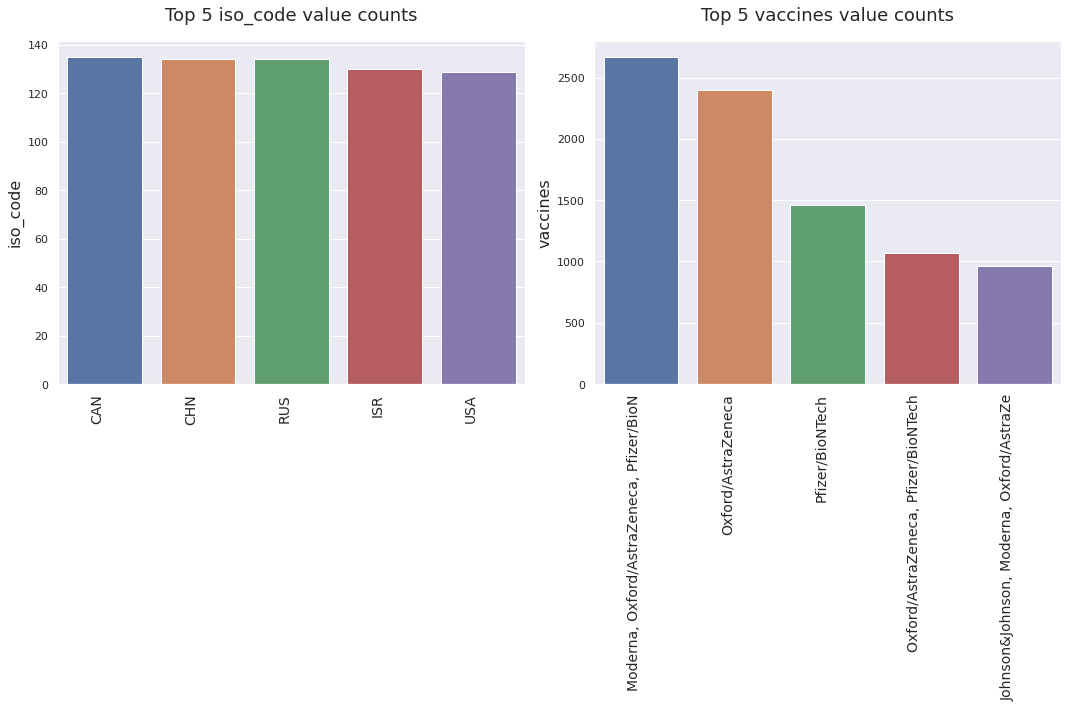

In [12]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')
                       
# Print top 10 Value counts for two important categorical columns
cols_to_visualize = ['iso_code', 'vaccines']
vz.plot_categorical_val_counts(covid_orig_df, cols_to_visualize, 
                                  print_values=False, top=5)

## Explore: Plot Column Correlations

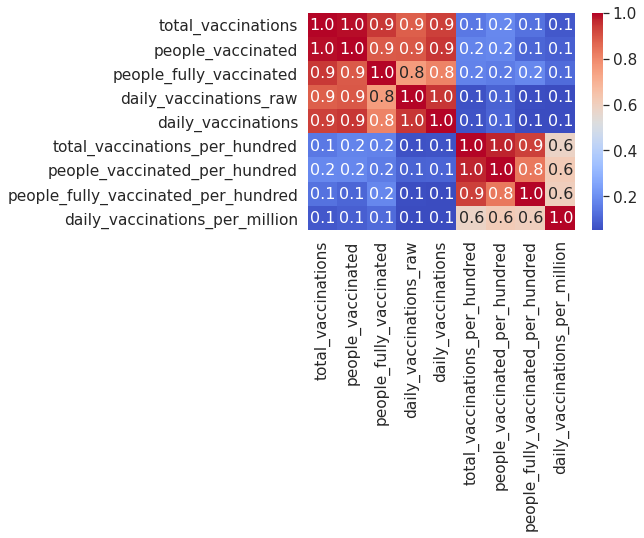

In [13]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Find Correlations between columns
cols_to_visualize = list(covid_orig_df.describe().columns)
vz.viz_columns_corr(covid_orig_df, cols_to_visualize)

## Explore: Plot Histograms for the numerical columns for the top Countries

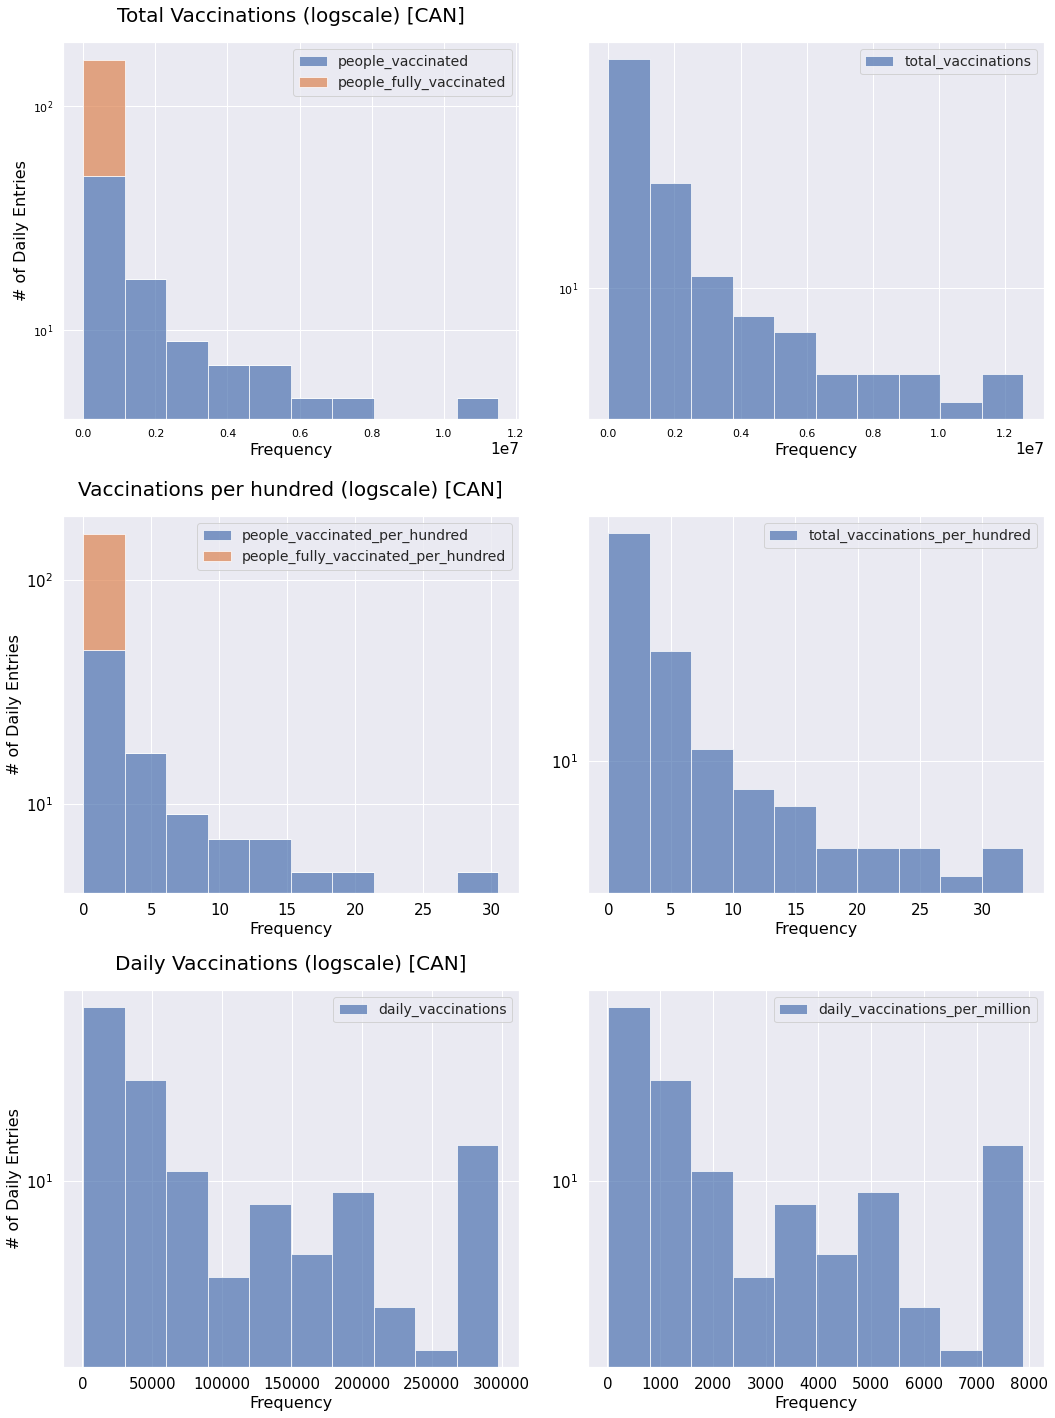

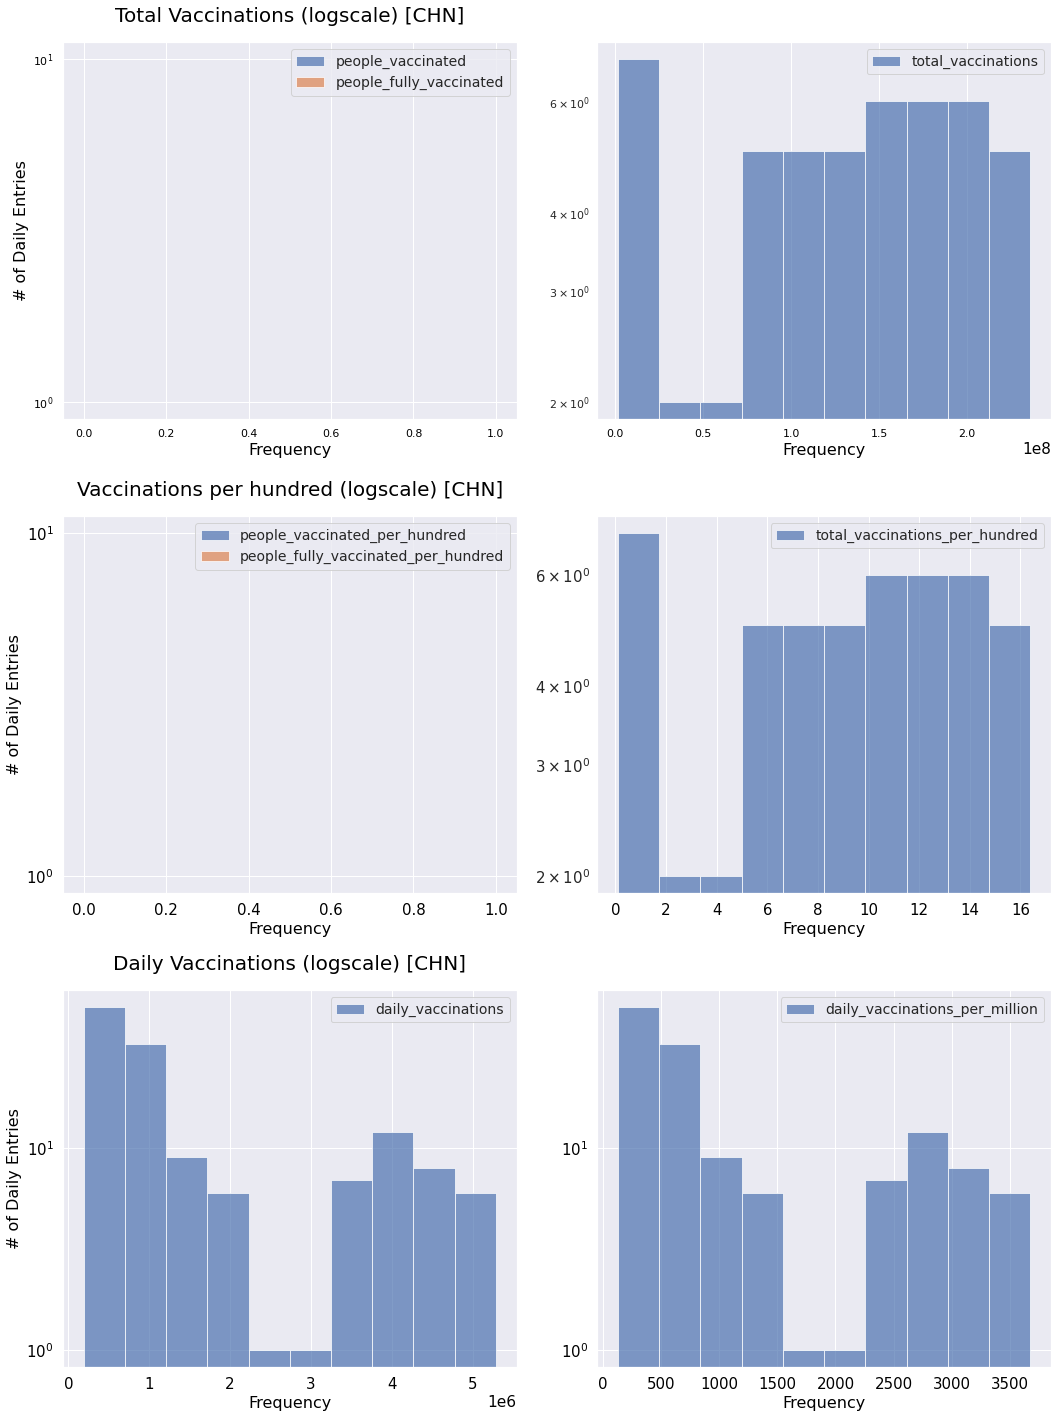

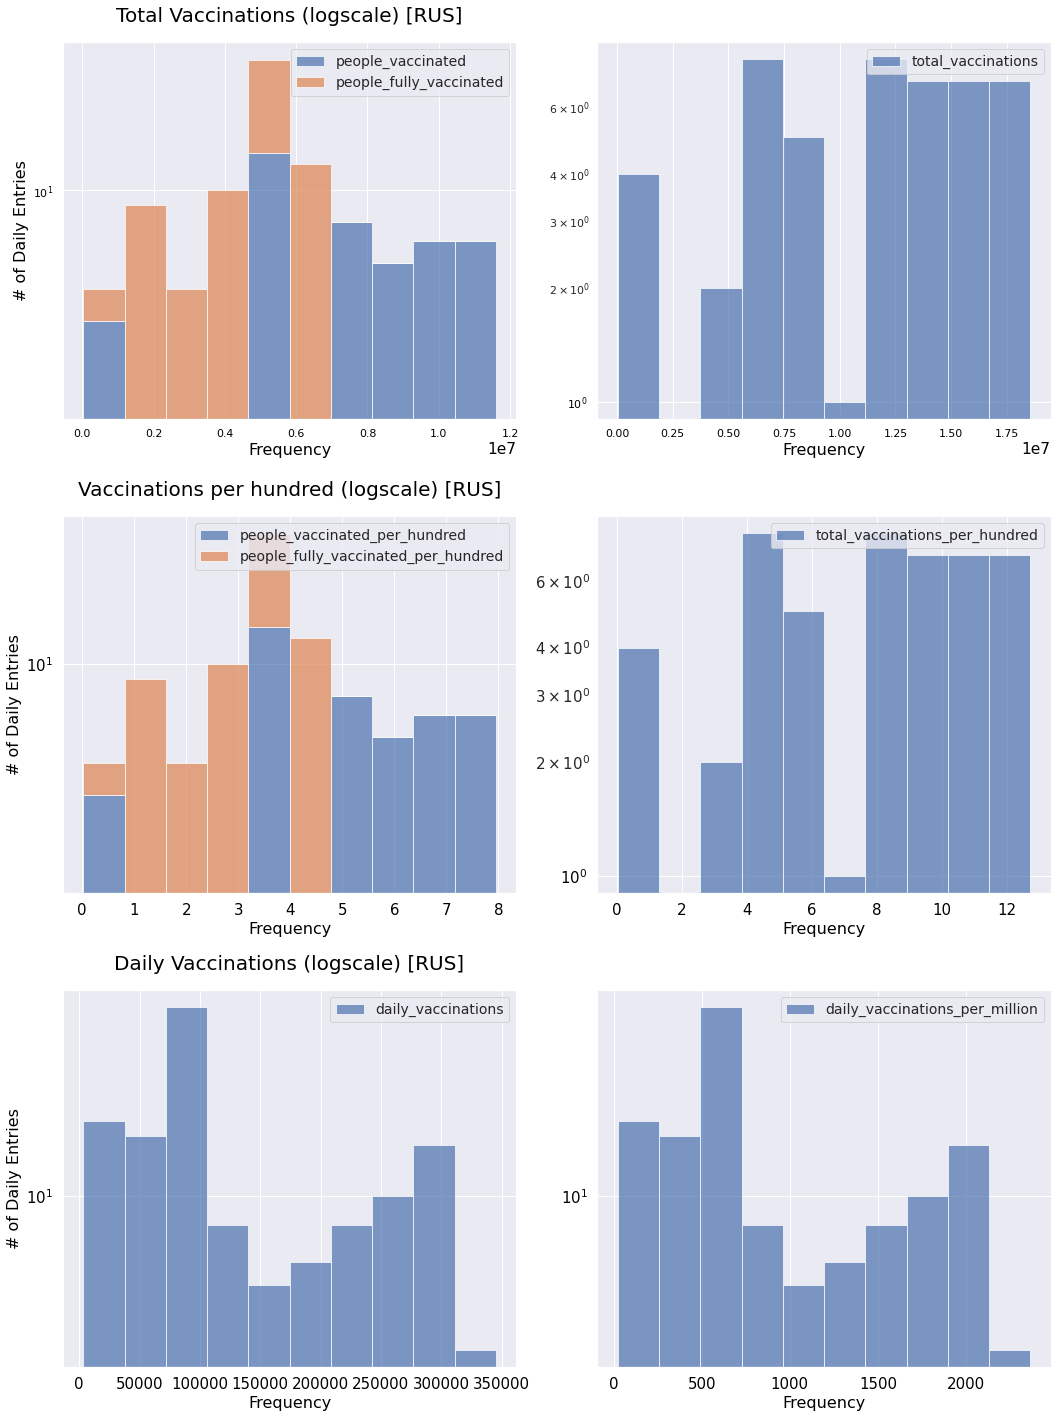

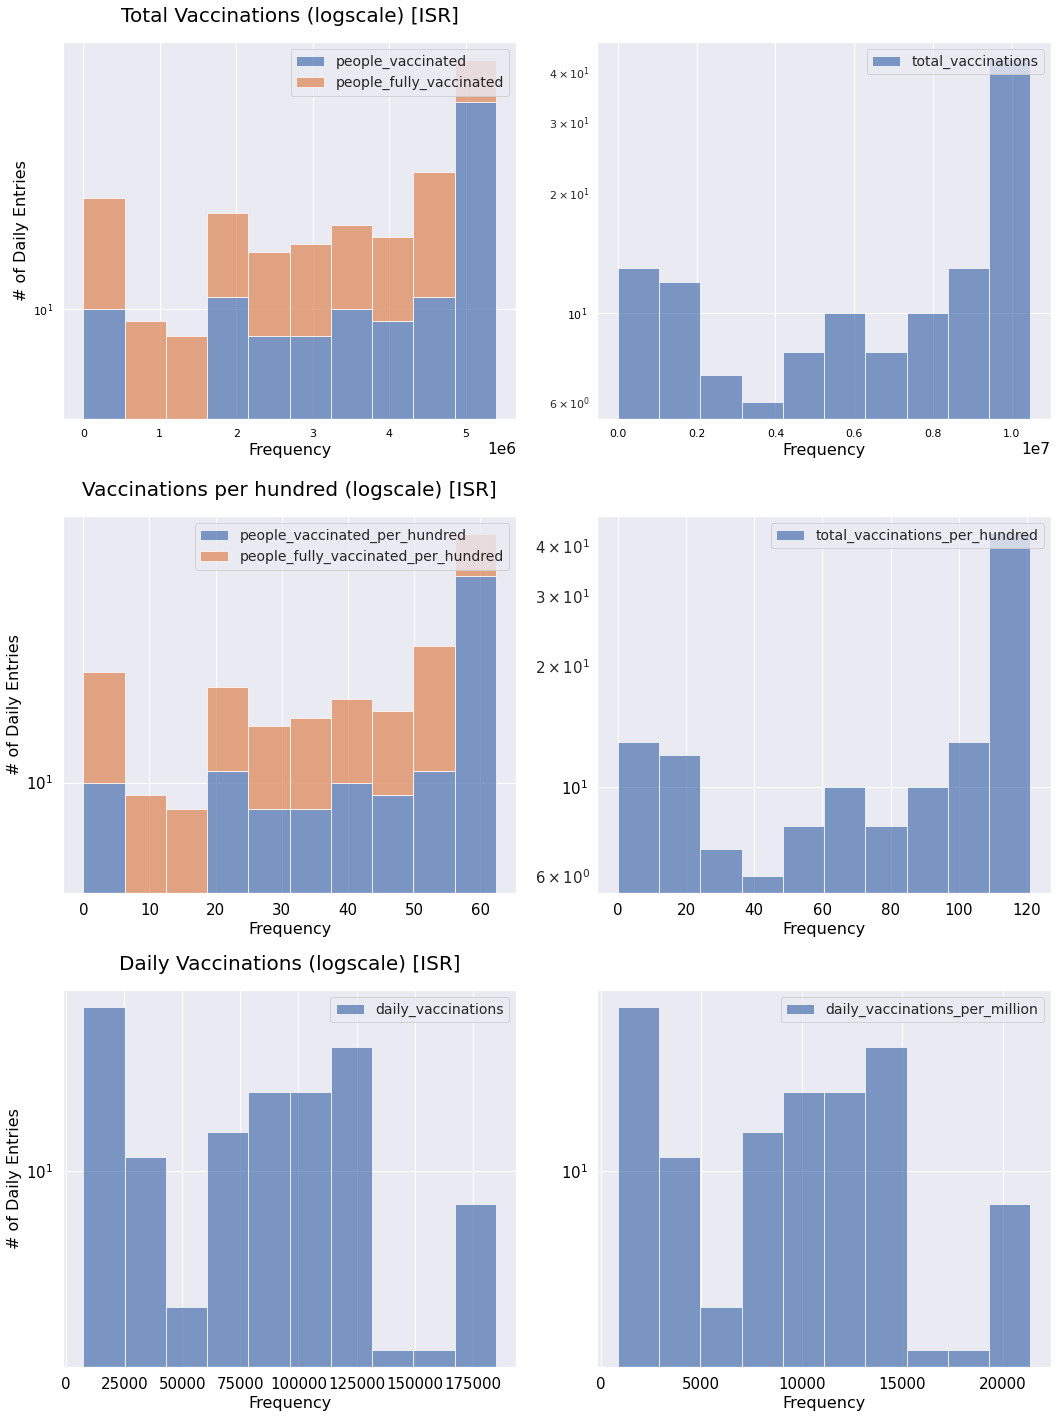

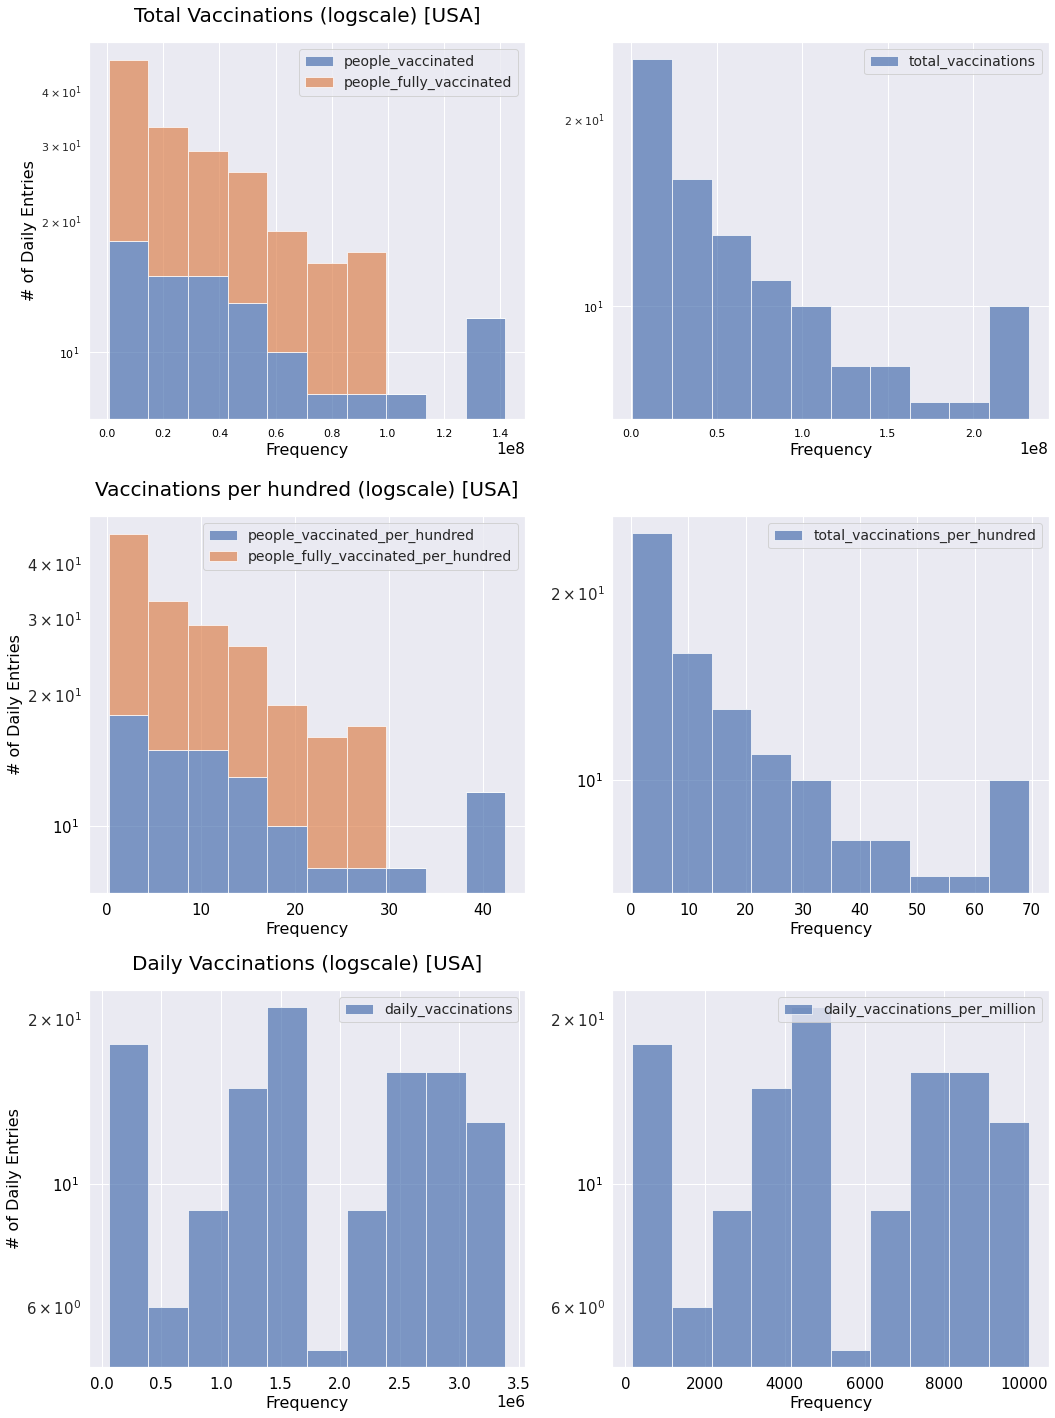

In [14]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Plot histograms with the values of important numerical columns
vz.plot_numerical_val_counts_per_country(covid_orig_df, top=5)

## Explore: Visualize null values

HeatMap Description
- -1: Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
- 0: No correlation represents that variables values present or absent do not have any effect on one another.
- 1: Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present

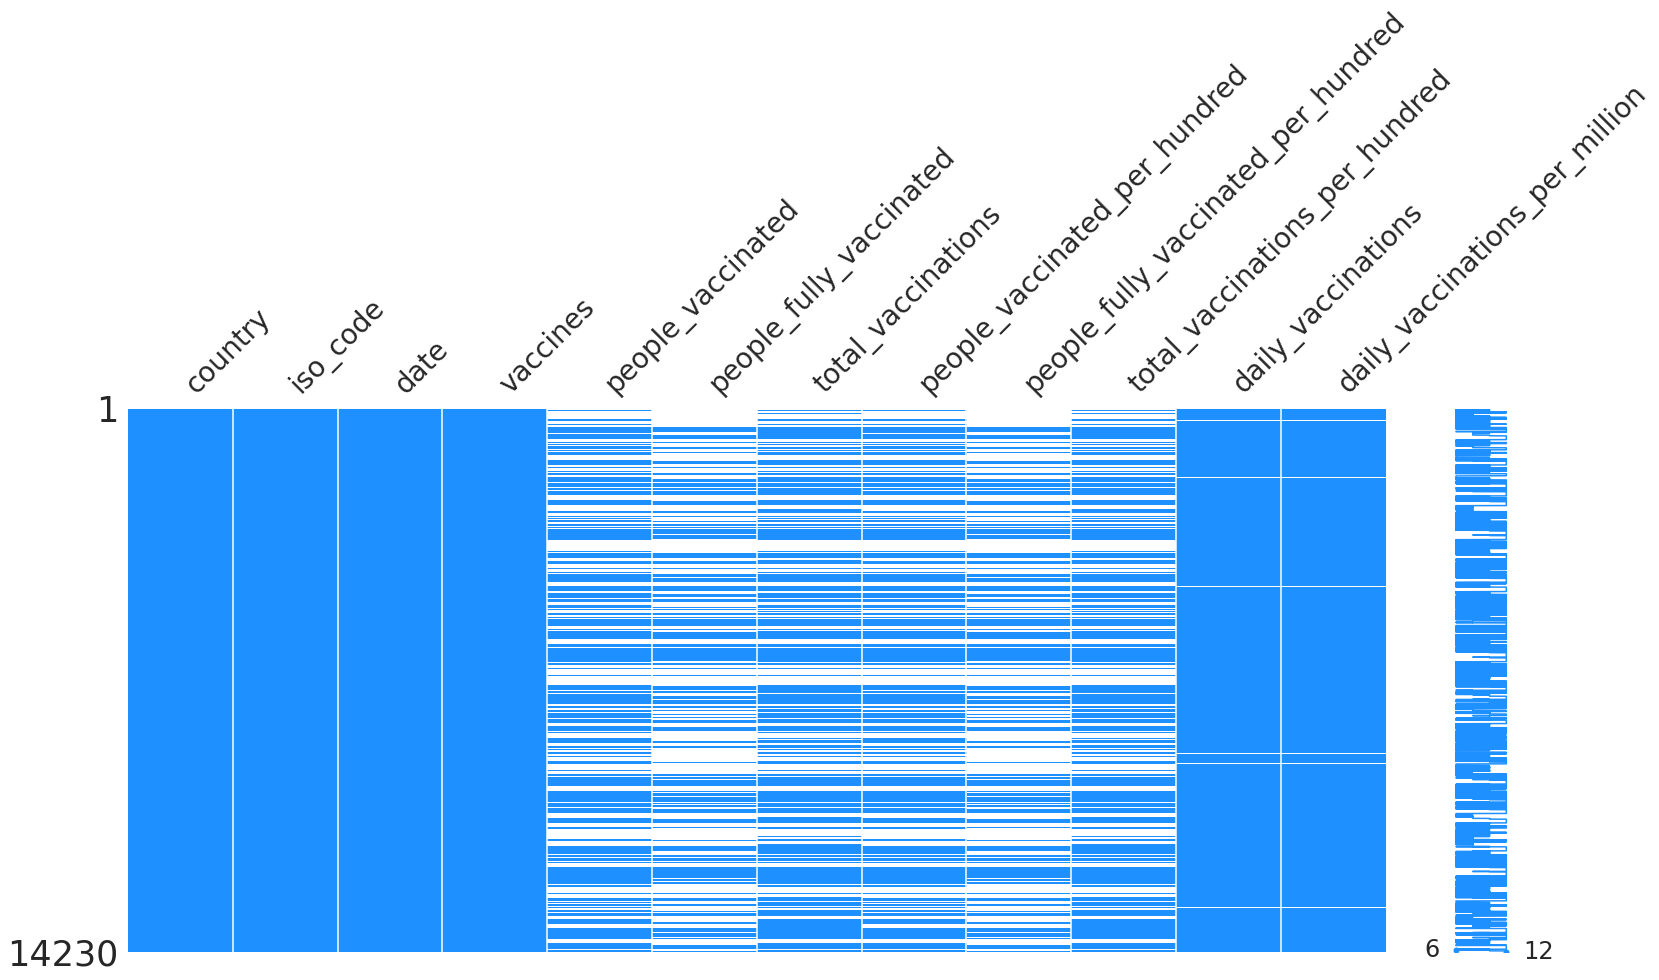

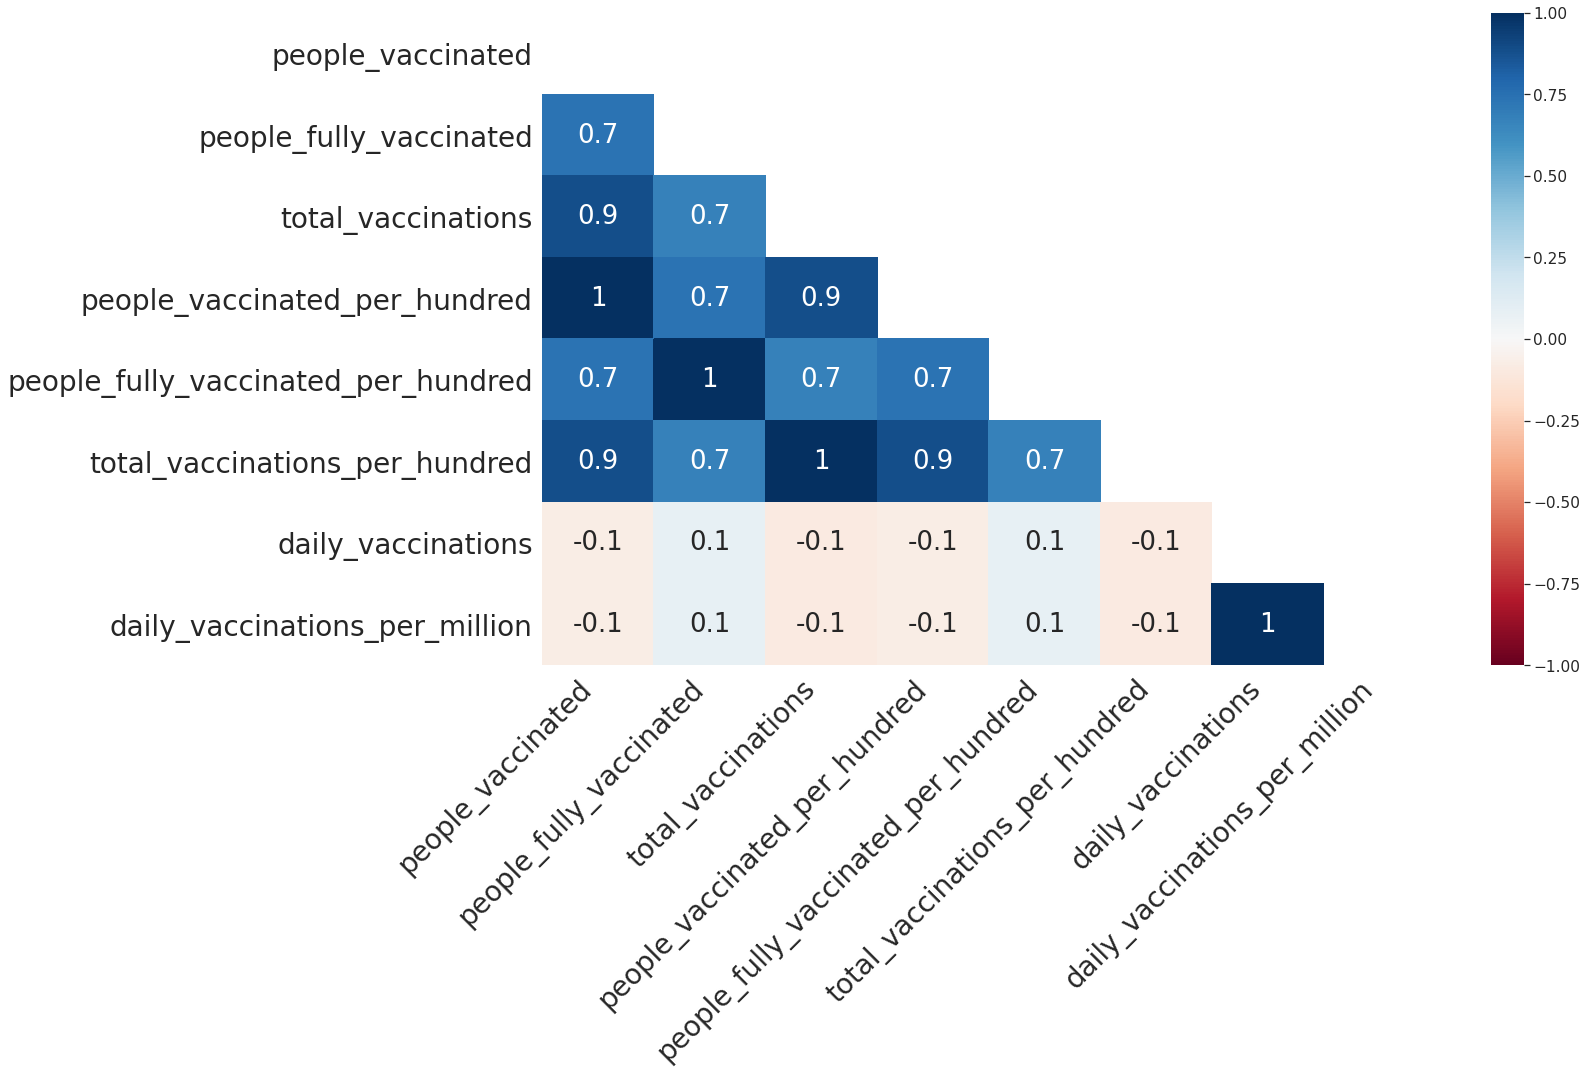

In [15]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Visualize Missing Values   
important_cols = ['country', 'iso_code', 'date', 'vaccines', 
                  'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations', 
                  'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
                  'total_vaccinations_per_hundred','daily_vaccinations', 
                  'daily_vaccinations_per_million']
vz.viz_missing_values(covid_orig_df, important_cols, 
                      skip_1=False, skip_2=False, print_values=False)

# Transform/Clean the dataset

In [54]:
# Drop Duplicates
covid_orig_df = covid_orig_df.sort_values(['date', 'iso_code']).drop_duplicates(subset=['date', 'iso_code'], keep='last')
# Transform Date to a datetime column
covid_orig_df['date'] = pd.to_datetime(covid_orig_df.date)

## Transform: Fixing Nulls
In the previous section we see that the columns with most missing values are:
- people_vaccinated 
- people_fully_vaccinated
- total_vaccinations
- people_vaccinated_per_hundred
- people_fully_vaccinated_per_hundred
- total_vaccinations_per_hundred

We also find that the missing values of daily_vaccinations and daily_vaccinations_per_million are not correlated with any other columns. It's of course obvious that columns with their per_hunder or per_million versions are always missing at the same time.


### Fix Nulls: First let's fix the **non** `per_hundred` and `per_million` columns:
- `daily_vaccinations`
- `total_vaccinations`
- `people_vaccinated`
- `people_fully_vaccinated`

In [17]:
def d(df, cols):
    """ Function for printing the number of nulls per column"""
    df = df.loc[:, cols]
    missings = df.isna().sum()    
    return missings

In [18]:
# New DF version
covid_df_1 = covid_orig_df.copy()

# Reload Lib    
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# Columns to print their missing values
cols = ['country', 'iso_code', 'date', 'daily_vaccinations', 'total_vaccinations',
        'people_vaccinated', 'people_fully_vaccinated']


# Print the Missing values before
missings = d(covid_df_1, cols)
logger.info(f"Missing Values Before:\n{missings}")

# Fix the NULLS
covid_df_1 = nf.fix_and_infer(covid_df_1)

# Print the Missing values before
missings = d(covid_df_1, cols)
logger.info(f"Missing Values After:\n{missings}")


2021-04-30 02:44:36 JupyterMain  INFO     Missing Values Before:
country                       0
iso_code                      0
date                          0
daily_vaccinations          197
total_vaccinations         5744
people_vaccinated          6380
people_fully_vaccinated    8498
dtype: int64
2021-04-30 02:51:50 JupyterMain  INFO     Missing Values After:
country                    0
iso_code                   0
date                       0
daily_vaccinations         0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
dtype: int64


### Fix Nulls: Now fix `per_hundred` and `per_million` columns:
- `daily_vaccinations_per_million`
- `total_vaccinations_per_hundred`
- `people_vaccinated_per_hundred`
- `people_fully_vaccinated_per_hundred`

#### Columns w/ perc.: First Load external dataset with countries metadata

This dataset contains population data for the countries and some other useful metadata.

In [19]:
# Load the metadata dataset
if covid_conf['type'] == 'csv':
    countries_meta_orig_df = pd.read_csv(data_extra_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')

2021-04-30 02:51:50 JupyterMain  INFO     Dataset loaded.


In [20]:
# Print Columns info
logger.info(f"Dataframe shape: {countries_meta_orig_df.shape}")
# Print the first two rows
display(countries_meta_orig_df.head(n=2))

2021-04-30 02:51:50 JupyterMain  INFO     Dataframe shape: (265, 11)


,,"Population, total","Community health workers (per 1,000 people)",Unnamed: 3,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)",People using at least basic sanitation services (% of population),"Hospital beds (per 1,000 people)",People with basic handwashing facilities including soap and water (% of population),"Physicians (per 1,000 people)","Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)"
0,Afghanistan,"38,041,754.0",..,NaN,9.4,64.5,43.4,0.4,37.7,0.3,13.9
1,Albania,"2,854,191.0",..,NaN,5.3,78.5,97.7,2.9,..,1.2,0.2


#### Columns w/ perc.: Transform the Metadata Dataset

1. Rename the columns
1. Drop Null Country rows
1. Fix the countries name to match our country names

In [21]:
# Preprocess the metadata dataset
countries_meta_df_1 = countries_meta_orig_df.copy()
# Rename Columns
name_replacements = {
    ' ': 'country',
    'Country Code': 'iso_code',
    'Population, total': 'population',
    'Community health workers (per 1,000 people)': 'health_workers_per_1000',
    'Current health expenditure (% of GDP)': 'health_expenditure_per_gdp',
    'Hospital beds (per 1,000 people)': 'hospital_beds_per_1000',
    'Life expectancy at birth, total (years)': 'life_expectancy_at_birth',
    'People using at least basic sanitation services (% of population)': 'perc_using_sanitation_services',
    'People with basic handwashing facilities including soap and water (% of population)': 'perc_using_handwashing_facilities',
    'Physicians (per 1,000 people)': 'physicians_per_1000',
    'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)': 'mortality_by_hygiene_per_100000'
}
countries_meta_df_1 = countries_meta_df_1.rename(columns=name_replacements)
# Drop unknown column
countries_meta_df_1 = countries_meta_df_1.drop(columns=["Unnamed: 3"])
# Drop Null Country rows
countries_meta_df_1 = \
        countries_meta_df_1[countries_meta_df_1['country'].notna()]
# Strip country column
countries_meta_df_1.loc[:, 'country'] = \
        countries_meta_df_1['country'].str.strip()
# Fix Country names
countries_meta_df_1.loc[:, 'country'] = countries_meta_df_1['country']\
                                            .replace('Czech Republic', 'Czechia')\
                                            .replace('Brunei Darussalam', 'Brunei')\
                                            .replace('Cabo Verde', 'Cape Verde')\
                                            .replace('Slovak Republic', 'Slovakia')\
                                            .replace('Korea, Rep.', 'South Korea')\
                                            .replace('Faroe Islands', 'Faeroe Islands')\
                                            .replace('Lao PDR', 'Laos')\
                                            .replace('Ireland', 'Northern Ireland')\
                                            .str.replace(', The', '')\
                                            .str.replace(r',.*Rep.', '')\
                                            .str.replace('&', 'and')\
                                            .str.replace('St\.', 'Saint')\
                                            .str.replace('n Federation', '')\
                                            .str.replace(', RB', '')\
                                            .str.replace(' SAR, China', '')
# Fix the population column
countries_meta_df_1.loc[:, 'population'] = countries_meta_df_1['population']\
                                                .str.replace(',', '')
# Print 2 rows
display(countries_meta_df_1.head(n=2))
logger.info(f"Countries Metadata Datatypes:\n{countries_meta_df_1.dtypes}")

,country,population,health_workers_per_1000,health_expenditure_per_gdp,life_expectancy_at_birth,perc_using_sanitation_services,hospital_beds_per_1000,perc_using_handwashing_facilities,physicians_per_1000,mortality_by_hygiene_per_100000
0,Afghanistan,38041754.0,..,9.4,64.5,43.4,0.4,37.7,0.3,13.9
1,Albania,2854191.0,..,5.3,78.5,97.7,2.9,..,1.2,0.2


2021-04-30 02:51:51 JupyterMain  INFO     Countries Metadata Datatypes:
country                              object
population                           object
health_workers_per_1000              object
health_expenditure_per_gdp           object
life_expectancy_at_birth             object
perc_using_sanitation_services       object
hospital_beds_per_1000               object
perc_using_handwashing_facilities    object
physicians_per_1000                  object
mortality_by_hygiene_per_100000      object
dtype: object


#### Columns w/ perc.: Check the Common countries between the two datasets

If Countries are missing check if they are important before dropping

In [22]:
# Check the overlap between the 2 datasets
unique_countries_covid = list(covid_df_1['country'].unique())
unique_countries_metadata = list(countries_meta_df_1['country'].unique())

# Do we have 100% Overlap?
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
answer = "Yes" if overlap else "No"
logger.info(f"Are all the countries from out dataset included in the metadata dataset? "\
            f"{answer}")
# Print the countries missing
not_included = set(unique_countries_covid).difference(unique_countries_metadata)
logger.info(f"Number of daily vaccination entries for the countruies not included:")
display(covid_df_1[covid_df_1['country'].isin(not_included)]\
                                                    .country.value_counts())

2021-04-30 02:51:51 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset? No
2021-04-30 02:51:51 JupyterMain  INFO     Number of daily vaccination entries for the countruies not included:


Ireland             116
Wales               114
England             114
Scotland            114
Northern Cyprus     100
Jersey               88
Guernsey             87
Anguilla             78
Montserrat           73
Falkland Islands     67
Saint Helena         66
Syria                39
Taiwan               38
Palestine            27
Kyrgyzstan           16
Timor                 1
Name: country, dtype: int64

#### Columns w/ perc.: Drop the countries missing from the Vaccianation Dataset

The countries that are missing are either:
1. non-officially recognized countries for which we have data in another form (e.g. UK included Scotland, and England)
2. There are not too many entries for them

In [23]:
# New DF version
covid_df_2 = covid_df_1.copy()

# Let's drop them as for example UK includes England, Wales, Scotland
logger.info("Dropping the missing countries..")
covid_df_2 = covid_df_2[~covid_df_2['country'].isin(not_included)]
unique_countries_covid = list(covid_df_2['country'].unique())
# Overlap
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
answer = "Yes" if overlap else "No"
logger.info(f"Are all the countries from out dataset included in the metadata dataset? " \
            f"{answer}")



2021-04-30 02:51:51 JupyterMain  INFO     Dropping the missing countries..
2021-04-30 02:51:51 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset? Yes


#### Columns w/ perc.: Use the new information to fix the `per_hunded` and `per_million` columns

In [24]:
# New DF version
countries_meta_df_2 = countries_meta_df_1.copy()

# Change the data types to numeric
metadata_cols = ['country', 'population', 'health_workers_per_1000', 'health_expenditure_per_gdp',
                 'hospital_beds_per_1000', 'life_expectancy_at_birth', 
                 'perc_using_sanitation_services', 'perc_using_handwashing_facilities', 
                 'physicians_per_1000', 'mortality_by_hygiene_per_100000']
for col in metadata_cols[1:]:
    countries_meta_df_2.loc[:, col] = pd.to_numeric(countries_meta_df_2[col], 
                                                          errors='coerce')

1. Divide the non `per_hundred` and `per_million` columns by the `population` column from the metadata dataset to infer their couterparts
1. Scale them in their 1-100 and 1-1 million ranges to fix errors
1. Transform the `per_million` column to `per_hundred`

In [25]:
# New DF version
covid_df_3 = covid_df_2.copy()

# Reload Lib
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# Recalculate the per 100 and per million values using the new dataset
covid_df_3 = nf.fill_with_population(covid_df_3, countries_meta_df_2)

# Then scale them to incorporate possible errors
# cols_to_scale = [("people_vaccinated_per_hundred", 100),
#                 ("people_fully_vaccinated_per_hundred", 100),
#                 ("total_vaccinations_per_hundred", 100), # can be > 100%
#                 ("daily_vaccinations_per_million", 1000000)]
# covid_df_3 = nf.scale_cols(covid_df_3, cols_to_scale)

# Transofrm the daily per million to daily per hundred
covid_df_3['daily_vaccinations_per_hundred'] = \
    covid_df_3['daily_vaccinations_per_million'] / 10000
# Drop the per million column
covid_df_3 = covid_df_3.drop(columns=['daily_vaccinations_per_million'])


***We are done with the handling of nulls!***

### Transform: Drop rows with total_vaccinations or daily_vaccinations == 0

Because they are irrelevant

In [26]:
covid_df_3 = covid_df_3[((covid_df_3.total_vaccinations>0) & (covid_df_3.daily_vaccinations>0))] 

### Transform: Data Enrichment

Let's utilize the metadata dataset and import some features to our vaccination Dataset

#### Enrichment: Visualize missing values on the Metadata Dataset

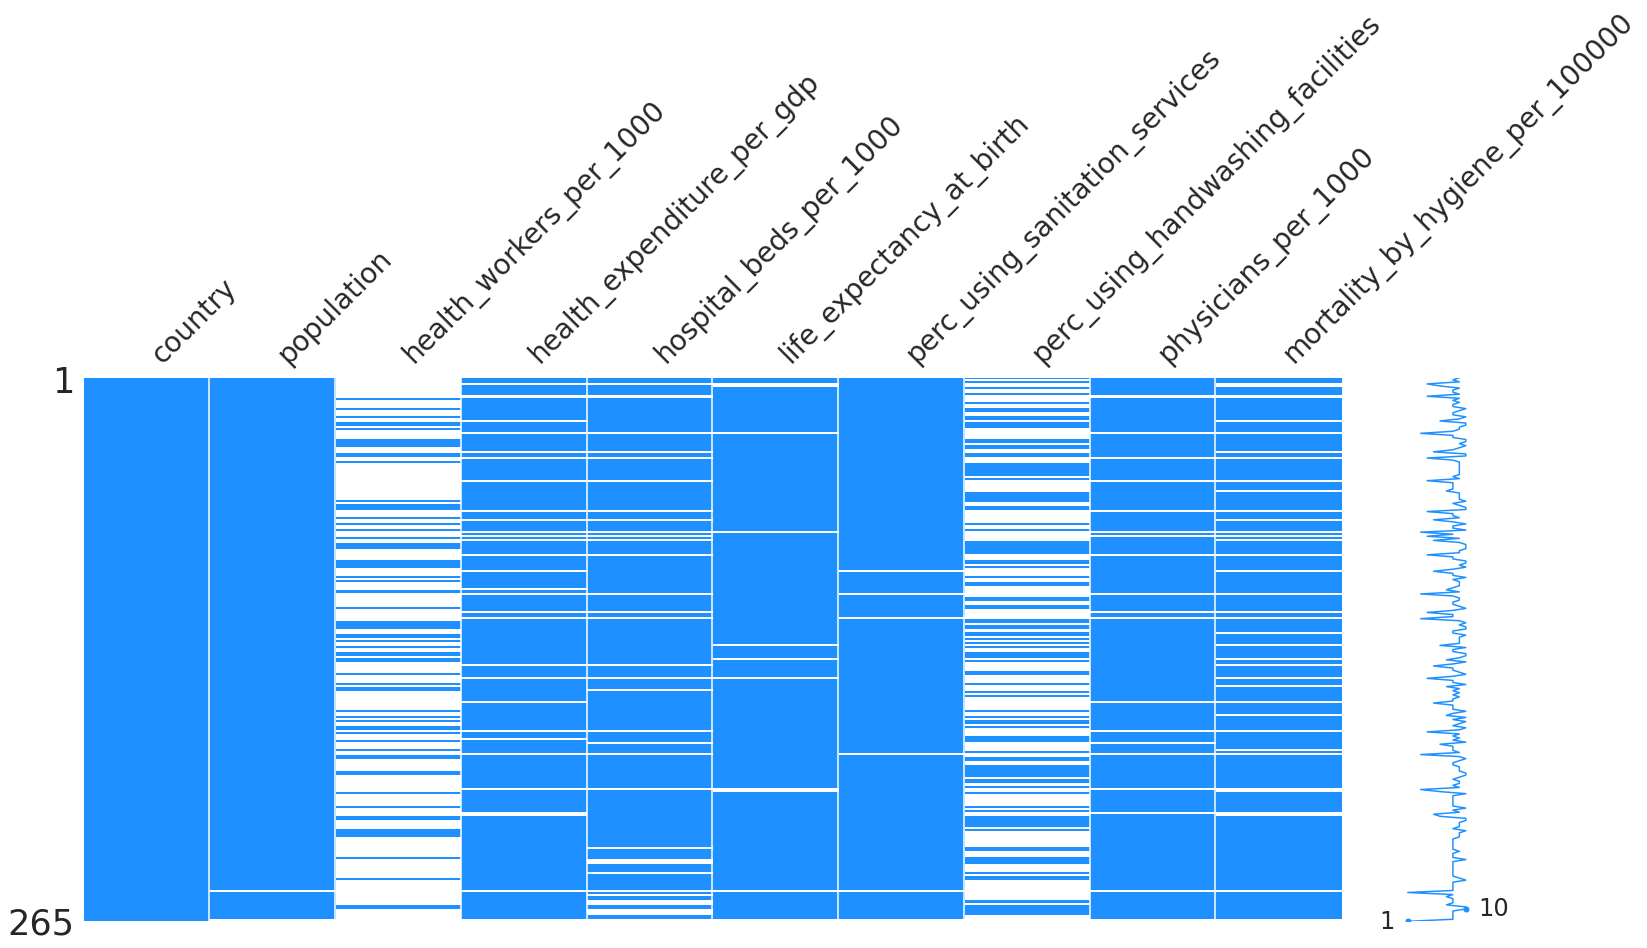

In [27]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Visualize 
vz.viz_missing_values(countries_meta_df_2, metadata_cols, 
                      skip_2=True, print_values=False)

#### Enrichment: Drop Columns with too many missing values

In [28]:
# New DF Version
countries_meta_df_3 = countries_meta_df_2.copy()

# Drop columns with many nulls
cols_to_drop = ["health_workers_per_1000", "perc_using_handwashing_facilities"]
countries_meta_df_3 = countries_meta_df_3.drop(columns=cols_to_drop)
metadata_cols_kept = list(set(metadata_cols).difference(set(cols_to_drop)))

#### Enrichment: Interpolate missing values

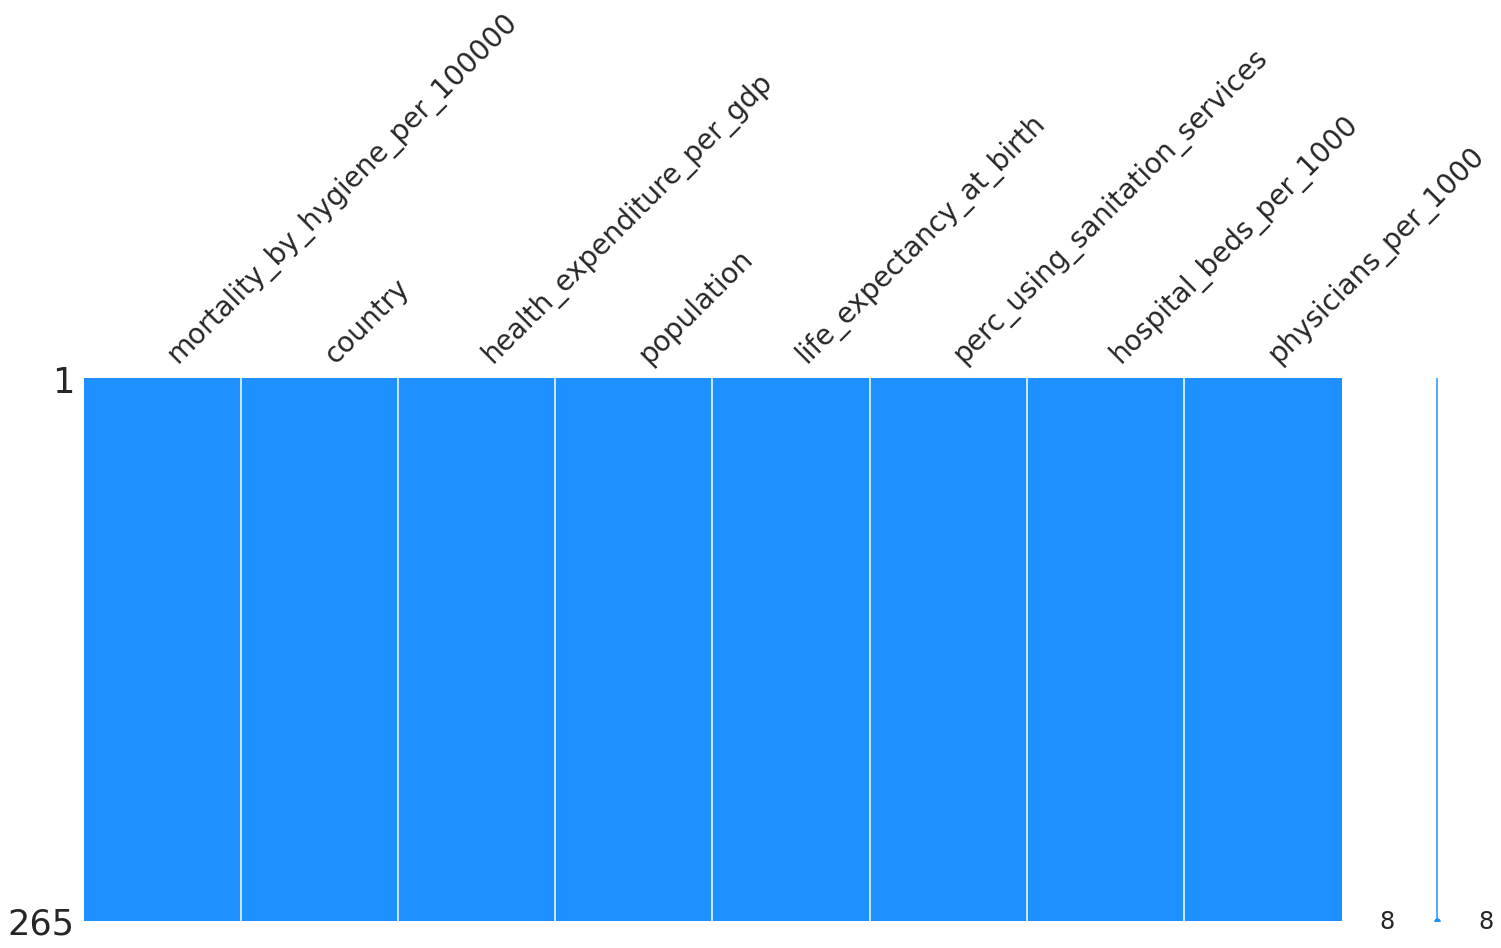

In [29]:
# New DF Version
countries_meta_df_4 = countries_meta_df_3.copy()

# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Fillna for the columns we kept using interpolation
countries_meta_df_4 = countries_meta_df_4.interpolate()
# Visualizer
vz.viz_missing_values(countries_meta_df_4, metadata_cols_kept, 
                      skip_2=True, print_values=False)

#### Enrichment: Merge our dataset with the metadata dataset

In [30]:
# New DF Version
covid_df_4 = covid_df_3.copy()
# Now match these values with the covid dataset
covid_df_4 = covid_df_4.merge(countries_meta_df_4, on='country', how='left')
# Print the first two rows
display(covid_df_4.head(2).transpose())

,0,1
country,Canada,Canada
iso_code,CAN,CAN
date,2020-12-14 00:00:00,2020-12-15 00:00:00
total_vaccinations,5,723
people_vaccinated,5,705
people_fully_vaccinated,0,18
daily_vaccinations_raw,NaN,718
daily_vaccinations,5,718
total_vaccinations_per_hundred,0,0
people_vaccinated_per_hundred,0,0


### Transform: Feature Engineering

#### Feat. Eng.: OneHotEncode Vaccines

In [42]:
# New DF Version
covid_df_5 = covid_df_4.copy()
# Print the first two vaccine rows
display(covid_df_5[['vaccines']].head(2))

# OneHotEncode the 'vaccines' columns
onehotencoded_df_1 = covid_df_5.vaccines.str\
                                   .split('\s*,\s*', expand=True)\
                                   .stack()\
                                   .str.get_dummies()\
                                   .add_prefix('vaccine_').sum(level=0)
# OneHotEncode the 'country' columns
# onehotencoded_df_2 = pd.get_dummies(covid_df_4.iso_code, prefix='country')

# Merge it with our dataset
covid_df_5 = covid_df_5.join(onehotencoded_df_1)#.join(onehotencoded_df_2)

# Print the first two rows
display(covid_df_5.head(2).transpose())


,vaccines
0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
1,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"


,0,1
country,Canada,Canada
iso_code,CAN,CAN
date,2020-12-14 00:00:00,2020-12-15 00:00:00
total_vaccinations,5,723
people_vaccinated,5,705
people_fully_vaccinated,0,18
daily_vaccinations_raw,NaN,718
daily_vaccinations,5,718
total_vaccinations_per_hundred,0,0
people_vaccinated_per_hundred,0,0


# Plot what we currenlty have

## Plot: Top countries with the best records

Regarding:
- Total vaccinations
- Total vaccinations per 100
- Avg daily vaccinations per 100

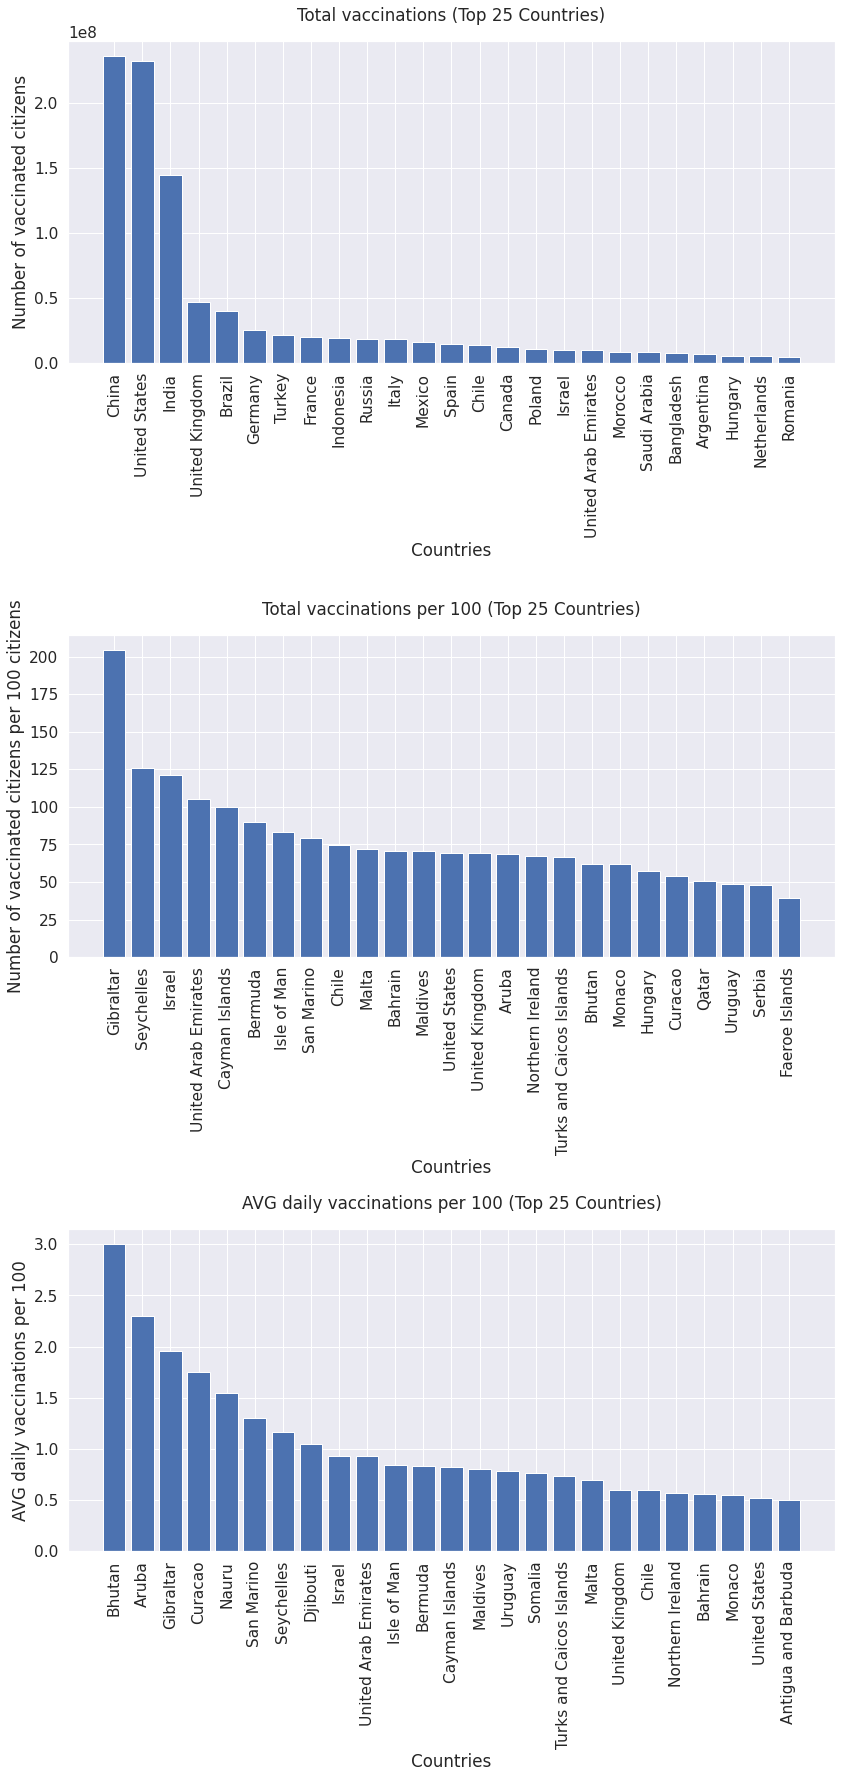

In [32]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='country', text_color='black')

# Plot the countries with best records on some of the columns
top_n = 25
vz.viz_top_countries_accumulated_statistics(covid_df_5, top_n=top_n)

## Plot: The daily progress of the top countries

Regarding:
- People vaccinated per 100
- People fully vaccinated per 100
- Total vaccinations per 100
- Daily vaccinations per 100

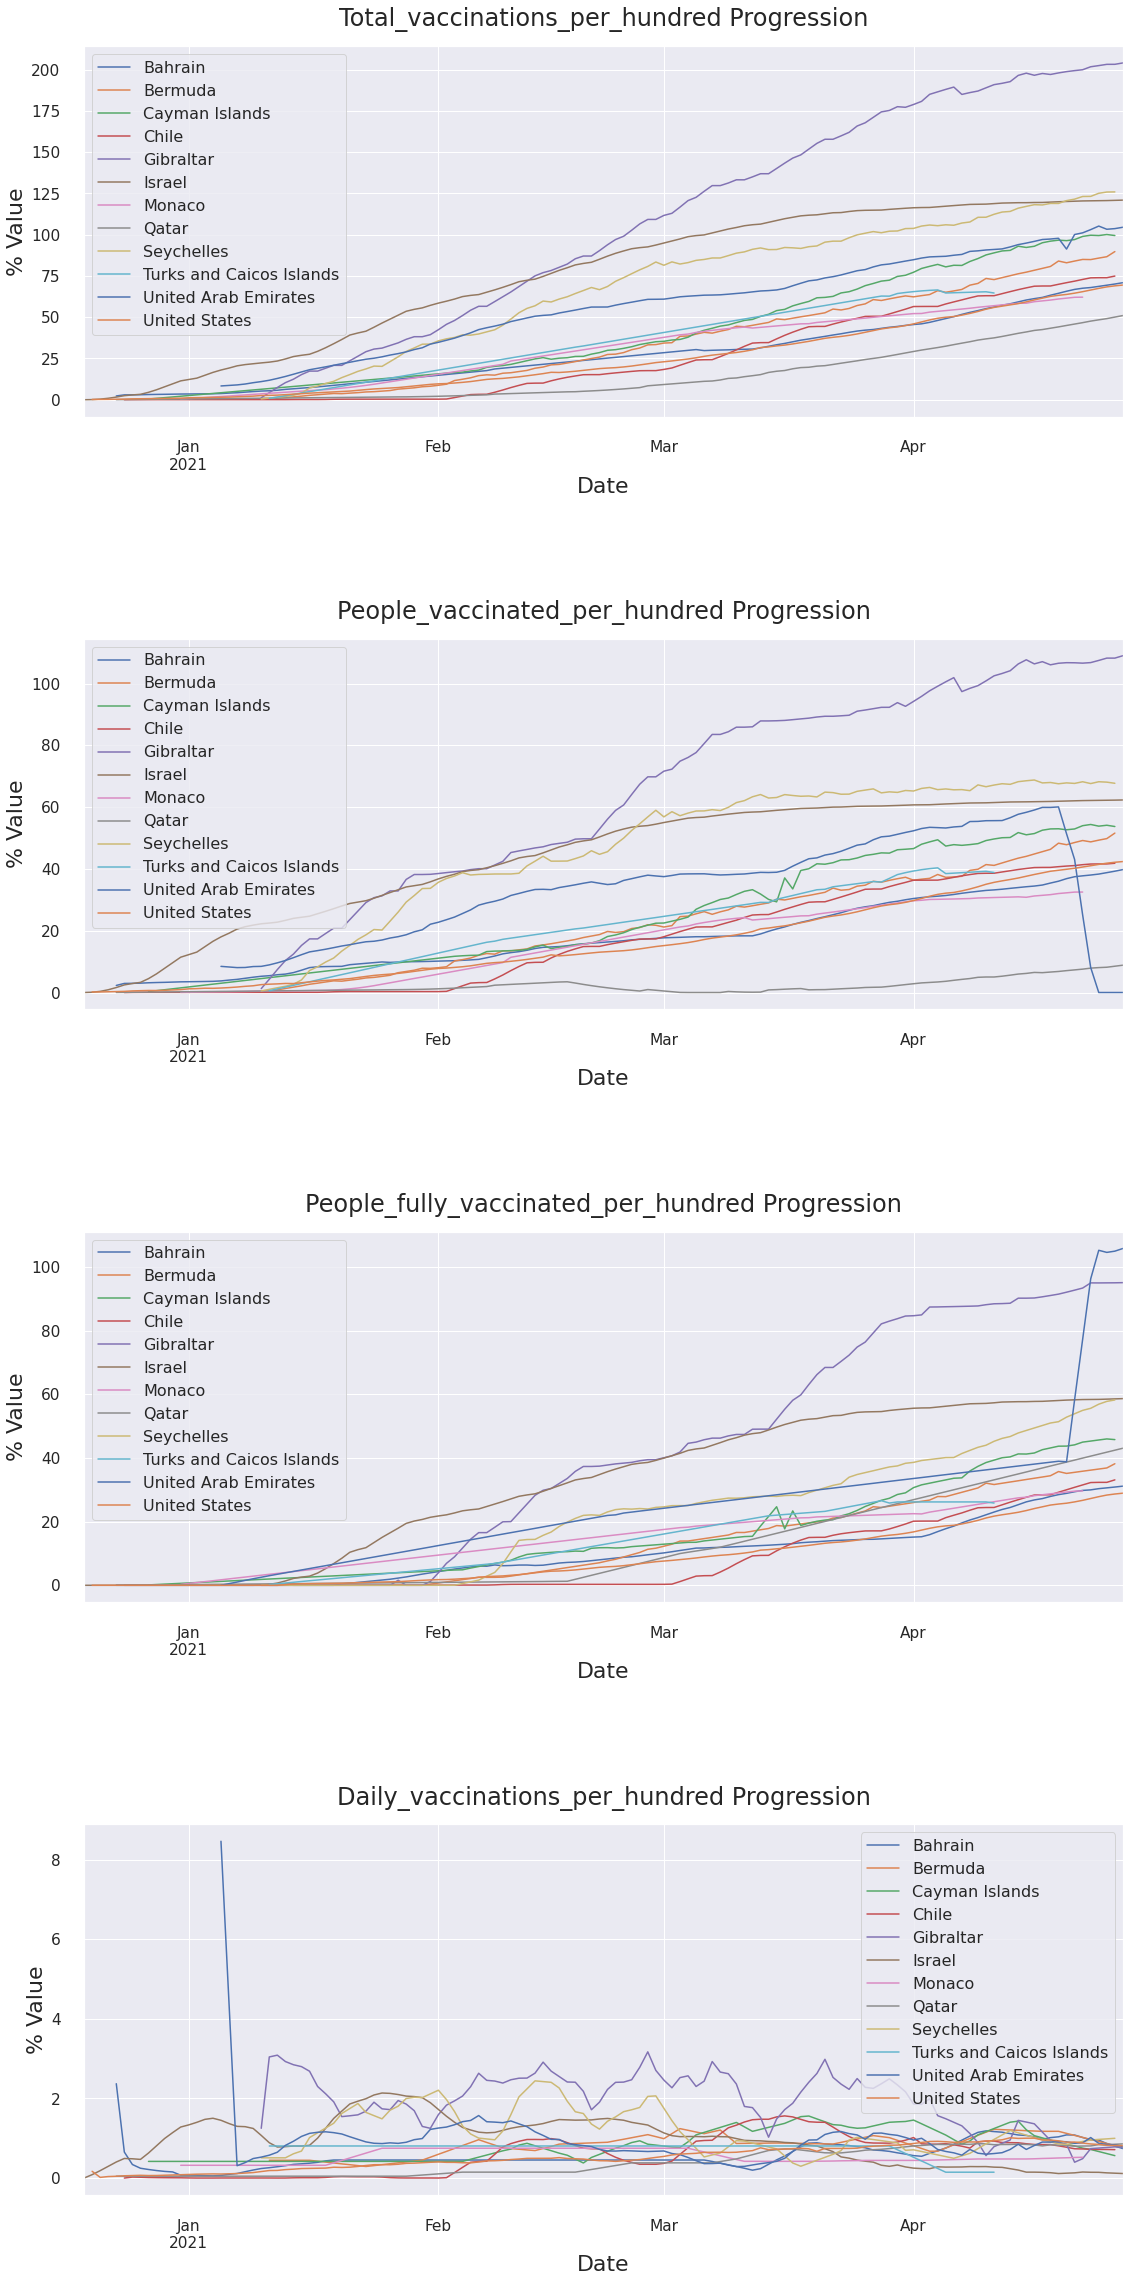

In [33]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='country', text_color='black')

# Plot the progress of the top n countries
top_n = 12
# top_sort_by = 'total_vaccinations_per_hundred'
# top_sort_by = 'people_vaccinated_per_hundred'
top_sort_by = 'people_fully_vaccinated_per_hundred'
# top_sort_by = 'daily_vaccinations_per_hundred'
vz.viz_top_countries_progress(covid_df_5, top_sort_by=top_sort_by, top_n=top_n)

2021-04-30 02:52:11 Visualizer   INFO     vaccine_Covaxin: 102
2021-04-30 02:52:11 Visualizer   INFO     vaccine_EpiVacCorona: 134
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Johnson&Johnson: 1148
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Moderna: 4044
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Oxford/AstraZeneca: 8724
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Pfizer/BioNTech: 8192
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Sinopharm/Beijing: 2265
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Sinopharm/Wuhan: 246
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Sinovac: 1810
2021-04-30 02:52:11 Visualizer   INFO     vaccine_Sputnik V: 1947


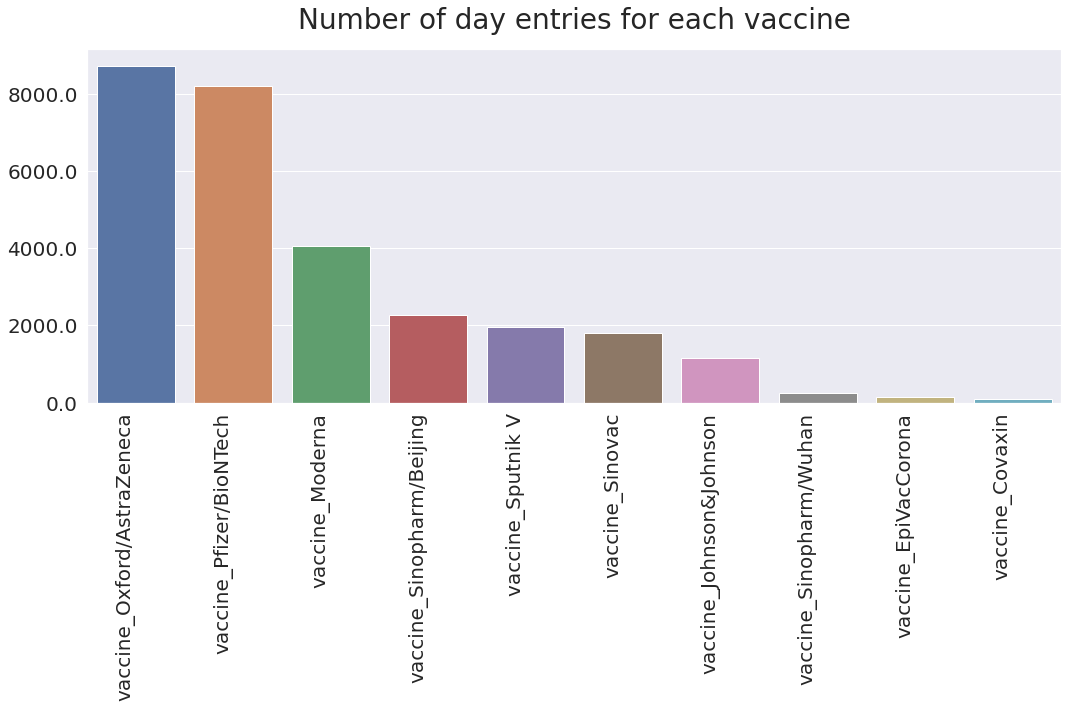

In [34]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Print top 10 Value counts for two important categorical columns
cols_to_visualize = ['vaccine_Covaxin', 'vaccine_EpiVacCorona', 'vaccine_Johnson&Johnson', 
                     'vaccine_Moderna', 'vaccine_Oxford/AstraZeneca', 'vaccine_Pfizer/BioNTech', 
                     'vaccine_Sinopharm/Beijing', 'vaccine_Sinopharm/Wuhan', 'vaccine_Sinovac', 
                     'vaccine_Sputnik V']
vz.plot_vaccines_val_counts(covid_df_5, cols_to_visualize, 
                             print_values=True, top=5)

# Training

Train an LSTM

In [35]:
import tensorflow as tf

In [112]:
covid_df_5.to_pickle('outputs/covid_df_5.pkl')
# covid_df_5 = pd.read_pickle('outputs/covid_df_5.pkl')

## Training: Set the Hyperparameters

In [174]:
loss_option = tf.keras.losses.MeanSquaredError()
epoch_option = 5
activation_option = 'linear'
window_option = 10
orignal_columns_option = ['daily_vaccinations', 'total_vaccinations', 
                          'people_vaccinated', 'people_fully_vaccinated',
                          'daily_vaccinations_per_hundred', 'total_vaccinations_per_hundred', 
                          'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']
max_scale_option = 1000000
train_split_option = 0.8
layer_weights_option = [800, 800, 400]
batch_size_option = 128

## Training: Drop irrelevant columns 

Let's keep two versions, one with the final columns from our dataset and one with the extra columns from the metadata dataset

In [175]:
# Backup and reload
covid_df_6 = covid_df_5.copy()

# Let's drop the columns we won't use
cols_to_drop = list(set(covid_df_5.columns).difference(set(orignal_columns_option)))
cols_to_drop.remove('date')
cols_to_drop.remove('iso_code')
# Let's drop the column we won't use
covid_df_6 = covid_df_6.drop(columns=cols_to_drop)

## Training: Drop rows from recent dates with missing countries

It's possible that for the last 7 days we will not have data for some Countries. Let's drop there rows as they will badly affect the training.

In [280]:
# Backup and reload
covid_df_7 = covid_df_6.copy()
reload_lib(preplib)
prep = preplib.Preprocess(sort_col='date', group_col='iso_code')

# Prepare dataset for split in train and test set
covid_df_7 = prep.prepare_for_split(covid_df_7, num_to_trim=30)


2021-04-30 21:15:13 Preprocess   INFO     1083 rows dropped.


## Training: Scale columns

In [281]:
# Backup and reload
covid_df_8 = covid_df_7.copy()
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# Scale Columns
cols_to_scale = [(orig_cols, max_scale_option) for orig_cols in orignal_columns_option]
covid_df_8, scalers, df_keys = nf.scale_cols(covid_df_8, cols_to_scale, per_group=True)

## Training: Pivot The Dataset

For each day, merge the values of each countries into new columns

In [282]:
# Backup and reload
covid_df_9 = covid_df_8.copy()
reload_lib(preplib)
prep = preplib.Preprocess(sort_col='date', group_col='iso_code')

# Expand/Pivot the columns
logger.info(f"# Shape before pivoting: {covid_df_9.shape}")
covid_df_9 = prep.expand_columns_on_country(covid_df_9)
logger.info(f"# Shape after pivoting: {covid_df_9.shape}")

# Keep a copy of these columns for recreating them later
original_columns = orignal_columns_option
after_pivot_columns = list(covid_df_9.columns)

2021-04-30 21:15:14 JupyterMain  INFO     # Shape before pivoting: (11882, 10)
2021-04-30 21:15:14 JupyterMain  INFO     # Shape after pivoting: (126, 1409)


## Training: Change Datatypes

Make all datatypes float64

In [283]:
# Backup and reload
covid_df_10 = covid_df_9.copy()

for column in covid_df_10.columns:
    if column != 'date':
        covid_df_10[column] = covid_df_10[column].astype(np.float64)

logger.info("Changed all numerical datatypes to float64.")

2021-04-30 21:15:14 JupyterMain  INFO     Changed all numerical datatypes to float64.


In [284]:
# covid_df_10
# covid_df_enriched_10

## Training: Build Model

In [285]:
# Backup and reload
covid_df_11 = covid_df_10.copy()
reload_lib(modellib)
bm = modellib.BuildModel(window_size=window_option)

# Make the dataset rows divisible by the window we specified
covid_df_11 = bm.trim_dataset(covid_df_11)

# Split into train and test
train, test, date_train_col, date_test_col = bm.split_dataset(covid_df_11, train_perc=train_split_option)

# Build model
model, train_x, train_y = bm.build_model(train, loss=loss_option, activation=activation_option, neurons_per_layer=layer_weights_option)

2021-04-30 21:15:14 BuildModel   INFO     Number of days in the dataset: 126
2021-04-30 21:15:14 BuildModel   INFO     Number of 10-day groups: 12 + 6 extra days
2021-04-30 21:15:14 BuildModel   INFO     Dropping the last 6 rows from the covid dataset
2021-04-30 21:15:14 BuildModel   INFO     Dropped 6 rows
2021-04-30 21:15:14 BuildModel   INFO     Train shape: (9, 10, 1408)
2021-04-30 21:15:14 BuildModel   INFO     Test shape: (3, 10, 1408)


# Train the Model

In [286]:
# Backup and reload
reload_lib(modellib)
bm = modellib.BuildModel(window_size=window_option)

# Train the model
verbose = 0
model = bm.train_model(model, train_x, train_y, epoch_option, batch_size, verbose)

## Training: Generate predictions

In [287]:
predictions = bm.generate_predictions_whole_group(train, test, model)

## Training: Recreate the test set and the predictions

In [288]:
# Rejoin the dataset
predictions_expanded_df, test_expanded_df = bm.rejoin_dataset(predictions, test, after_pivot_columns, date_test_col)

# Unpivot the Dataframes
test_df = prep.contract_columns_on_country(test_expanded_df, original_columns)
predictions_df = prep.contract_columns_on_country(predictions_expanded_df, original_columns)

# Unscale the columns
test_df = nf.unscale_cols(test_df, cols_to_scale, scalers, df_keys, per_group=True)
predictions_df = nf.unscale_cols(predictions_df, cols_to_scale, scalers, df_keys, per_group=True)

# Sort them by date and country
cols_of_interest = ['date', 'iso_code'] + original_columns
test_df = test_df[cols_of_interest].sort_values(['date', 'iso_code']).reset_index(drop=True)
predictions_df = predictions_df[cols_of_interest].sort_values(['date', 'iso_code']).reset_index(drop=True)

logger.info("Test DF and Predictions DF reshaped to the original format")

2021-04-30 21:15:23 JupyterMain  INFO     Test DF and Predictions DF reshaped to the original format


# Evaluation

## Evaluation: Visualize results

In [289]:
cou = ['ABW', 'CUW']
a = test_df[test_df.iso_code.isin(cou)].sort_values(['date', 'iso_code'])
display(a[['date', 'iso_code', 'daily_vaccinations_per_hundred']].iloc[-50:].head())

,date,iso_code,daily_vaccinations_per_hundred
2225,2021-03-29,ABW,24.2400
2257,2021-03-29,CUW,12.4500
2381,2021-03-30,ABW,1.1970
2413,2021-03-30,CUW,0.5338
2537,2021-03-31,ABW,1.1970


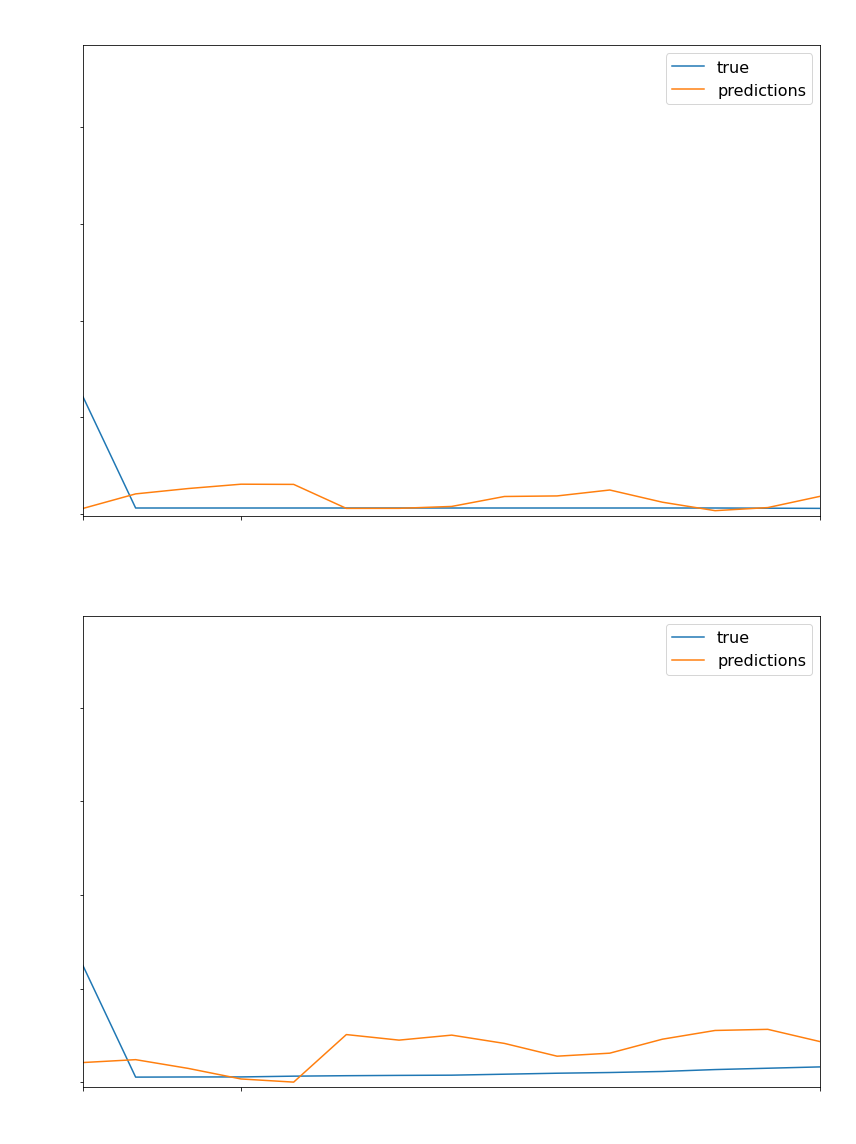

In [293]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='white')

# Plot the progress of the top n countries
top_n = 2
plot_col = 'daily_vaccinations_per_hundred'
vz.viz_evaluate_predictions_progress(test_df, predictions_df, plot_col=plot_col, top_n=top_n)

## Evaluation: Calculate evaluation metrics

In [325]:
# Backup and reload
reload_lib(modellib)
bm = modellib.BuildModel(window_size=window_option)

scores_df = bm.evaluate_predictions(test_df[['date', 'iso_code', 'daily_vaccinations_per_hundred']], 
                                    predictions_df[['date', 'iso_code', 'daily_vaccinations_per_hundred']])
display(scores_df.head())

,date,iso_code,rmse
0,2021-03-14,AFG,0.005011
1,2021-03-14,AGO,0.008191
2,2021-03-14,ALB,0.135224
3,2021-03-14,AND,0.669220
4,2021-03-14,ARE,2.369145


In [329]:
# Backup and reload
reload_lib(modellib)
bm = modellib.BuildModel(window_size=window_option)

# Summarize scores
total_avg, per_date_avg, per_country_avg = bm.summarize_scores(scores_df)
logger.info(f"Total Average RMSE: {total_avg}")

2021-04-30 22:13:40 JupyterMain  INFO     Total Average RMSE: 0.24518211492056968


## Evaluation: Visualizer errors

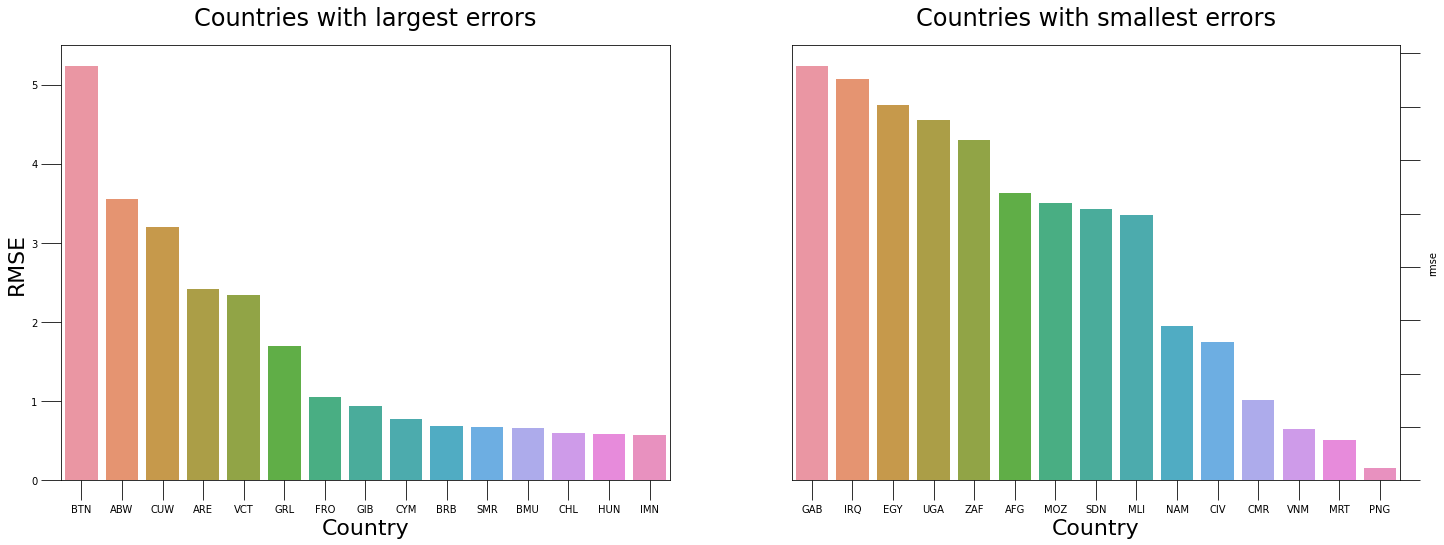

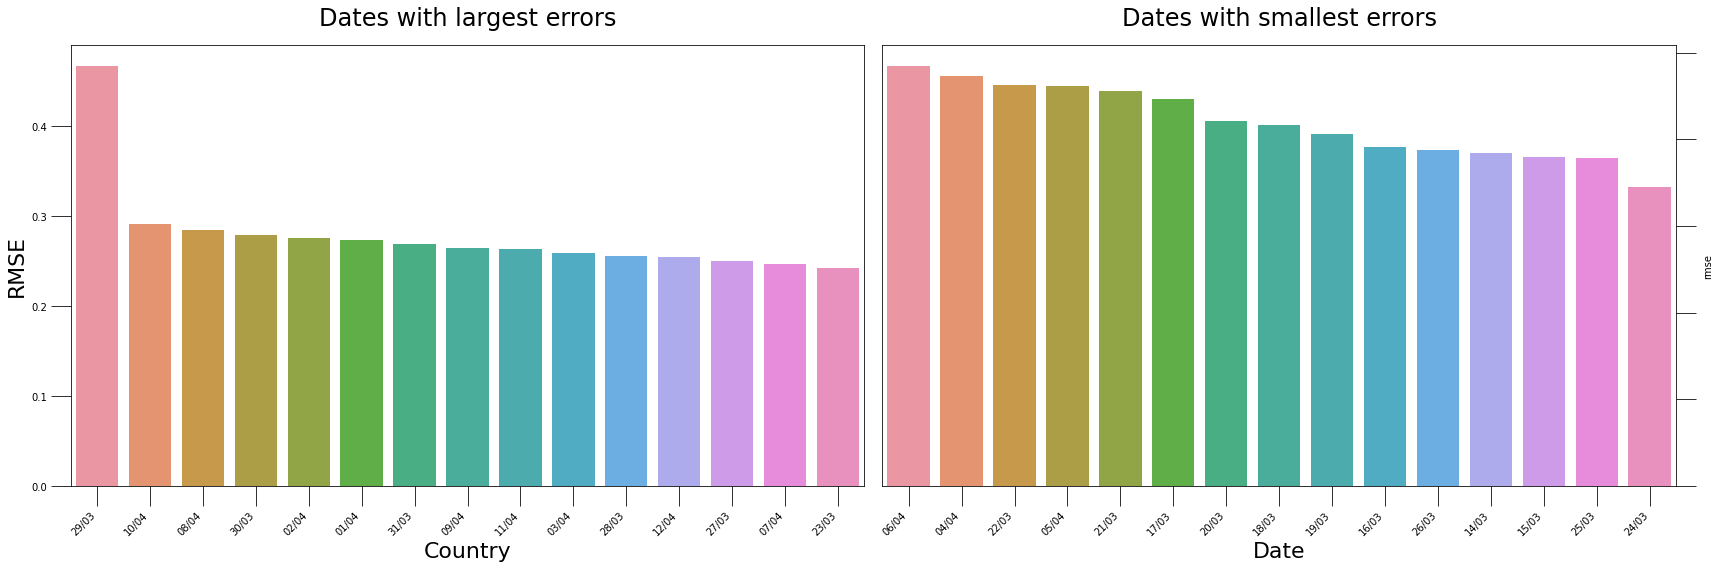

In [384]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='white')

# Plot the progress of the top n countries
top_n = 15
vz.viz_erros(per_date_avg, per_country_avg, top_n=top_n)

# Hyperparameter Tuning

In [ ]:
from itertools import product
loss_options = [tf.keras.losses.MeanSquaredError()]
# loss_options = [tf.keras.losses.CosineSimilarity(), tf.keras.losses.MeanAbsoluteError(),
#                tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.losses.MeanSquaredError(), 
#                 tf.keras.losses.MeanSquaredLogarithmicError()]
epoch_options = [5]
activation_options = ['linear']
window_options = [10]
original_columns_options = []
original_columns_options.append(['daily_vaccinations', 'total_vaccinations', 
                                 'people_vaccinated', 'people_fully_vaccinated',
                                'daily_vaccinations_per_hundred', 'total_vaccinations_per_hundred', 
                                 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred'])
max_scale_options = [1000000]
train_split_options = [0.8]
layer_weights_options = []
layer_weights_options.append([800, 800, 400])
batch_size_options = [128]
hyperparameters =  list(product(loss_options, epoch_options, activation_options, window_options, original_columns_options, 
                                max_scale_options, train_split_options, layer_weights_options, batch_size_options))
logger.info(f"Testing {len(hyperparameters)} hyperaparameters..")
for (loss_option, epoch_option, activation_option, window_option, orignal_columns_option, max_scale_option, train_split_option, layer_weights_option, batch_size_option) in hyperparameters:
    # Reload Libs
    reload_lib(preplib)
    reload_lib(nullib)
    reload_lib(vizlib)
    reload_lib(modellib)
    reload_lib(nullib)
    nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')
    prep = preplib.Preprocess(sort_col='date', group_col='iso_code')
    nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')
    vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='lightgrey')
    bm = modellib.BuildModel(window_size=window_option)
        
    # Drop date and iso_code Columns
    covid_df_6 = covid_df_5.copy()
    cols_to_drop = list(set(covid_df_5.columns).difference(set(orignal_columns_option)))
    cols_to_drop.remove('date')
    cols_to_drop.remove('iso_code')
    # Let's drop the column we won't use
    covid_df_6 = covid_df_6.drop(columns=cols_to_drop)   
    
    # Prepare dataset for split in train and test set
    covid_df_7 = covid_df_6.copy()
    covid_df_7 = prep.prepare_for_split(covid_df_7, num_to_trim=3)
    
    # Scale Columns
    covid_df_8 = covid_df_7.copy()
    cols_to_scale = [(orig_cols, max_scale_option) for orig_cols in orignal_columns_option]
    covid_df_8, scalers, df_keys = nf.scale_cols(covid_df_8, cols_to_scale, per_group=True)
    
    # Expand/Pivot the columns
    covid_df_9 = covid_df_8.copy()
    covid_df_9 = prep.expand_columns_on_country(covid_df_9)    
    # Keep a copy of these columns for recreating them later
    original_columns = orignal_columns_option
    after_pivot_columns = list(covid_df_9.columns)
    
    # Change the datatypes
    covid_df_10 = covid_df_9.copy()    
    for column in covid_df_10.columns:
        if column != 'date':
            covid_df_10[column] = covid_df_10[column].astype(np.float64)
    
    # Make the dataset rows divisible by the window we specified
    covid_df_11 = covid_df_10.copy()    
    covid_df_11 = bm.trim_dataset(covid_df_11)

    # split into train and test
    train, test, date_train_col, date_test_col = bm.split_dataset(covid_df_11, train_perc=train_split_option)

    # evaluate model and get scores
    verbose, epochs, batch_size = 0, epoch_option, batch_size_option
    # fit model
    num_features = train.shape[2]
    model = bm.build_model(train, bm.window_size, verbose, epochs, batch_size, num_features, 
                           loss_option=loss_option, activation_option=activation_option, neurons_per_layer=layer_weights_option)

    # Reload Lib
    reload_lib(modellib)
    bm = modellib.BuildModel(window_size=window_option)

    predictions = bm.generate_predictions_whole_group(train, test, model)
    # Rejoin the dataset
    predictions_expanded_df, test_expanded_df = bm.rejoin_dataset(predictions, test, after_pivot_columns, date_test_col)
    
    # Unpivot the Dataframes
    test_df = prep.contract_columns_on_country(test_expanded_df, original_columns)
    predictions_df = prep.contract_columns_on_country(predictions_expanded_df, original_columns)
    # Unscale the columns
    test_df = nf.unscale_cols(test_df, cols_to_scale, scalers, df_keys, per_group=True)
    predictions_df = nf.unscale_cols(predictions_df, cols_to_scale, scalers, df_keys, 
                                     per_group=True)

    # Sort them by date and country
    cols_of_interest = ['date', 'iso_code'] + original_columns
    test_df = test_df[cols_of_interest].sort_values(['date', 'iso_code'])\
                                       .reset_index(drop=True)
    predictions_df = predictions_df[cols_of_interest].sort_values(['date', 'iso_code'])\
                                                     .reset_index(drop=True)

    # Log
    logger.info("Test DF and Predictions DF reshaped to the original format")

    
    # Plot the progress of the top n countries
    top_n = 10
    top_sort_by = orignal_columns_option[0]
    logger.info(f"loss={loss_option}, epoch={epoch_option}, activation={activation_option}, window={window_option}, "\
                f"max_scale={max_scale_option}, train_perc={train_split_option}, batch_size={batch_size_option}")
    logger.info(f"Layer Weights:\n{layer_weights_option}")
    logger.info(f"Columns:\n{orignal_columns_option}")
    vz.viz_evaluate_predictions_progress(test_df, predictions_df, 
                                         top_sort_by=top_sort_by, top_n=top_n)